# Article Page Views API Example
This example illustrates how to access page view data using the [Wikimedia REST API](https://www.mediawiki.org/wiki/Wikimedia_REST_API). This example shows how to request monthly counts of page views for one specific article. The API documentation, [pageviews/per-article](https://wikimedia.org/api/rest_v1/#/Pageviews%20data), covers additional details that may be helpful when trying to use or understand this example.

## License
This code example was developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.3 - August 16, 2024



In [1]:
import json, time, urllib.parse
# The 'requests' module is not a standard Python module. You will need to install this with pip/pip3 if you do not already have it
import requests

# the following libraries were used for the homework, not included in the example notebook
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates

The example relies on some constants that help make the code a bit more readable.

In [5]:
#########

# Code to load csv file containing article names into a dataframe and iterate into the ARTICLE_TITLES list

rare_disease_cleaned = pd.read_csv('rare_disease_cleaned.AUG.2024.csv')

# Extract the values from the "disease" column, excluding the header
ARTICLE_TITLES = rare_disease_cleaned['disease'][0:].tolist()

# Display the resulting list
#print(ARTICLE_TITLES[0:10])


['Klinefelter syndrome', 'Aarskog–Scott syndrome', 'Abetalipoproteinemia', 'MT-TP', 'Ablepharon macrostomia syndrome', 'Acanthocheilonemiasis', 'Acanthosis nigricans', 'Aceruloplasminemia', 'Megaesophagus', 'Achard–Thiers syndrome']


In [15]:
#########
#
#    CONSTANTS
#

# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include your email address which will allow them
# to contact you if something happens - such as - your code exceeding rate limits - or some other error 
REQUEST_HEADERS = {
    'User-Agent': '<uwnetid@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2023',
}

# This is just a list of English Wikipedia article titles that we can use for example requests
#ARTICLE_TITLES = [ 'Bison', 'Northern flicker', 'Red squirrel', 'Chinook salmon', 'Horseshoe bat' ]

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.

def set_access_type(access_type):
    if access_type == "desktop":
        access = "desktop"
    elif access_type == "mobile-app":
        access = "mobile-app"
    elif access_type == "mobile-web":
        access = "mobile-web"
    elif access_type == "all-access":
        access = "all-access"
    else:
        raise ValueError("Choose ONLY from desktop, mobile-app, mobile-web, or all-access.")

    return access

# Example usage
access_type = "desktop"  # toggle between to "mobile-app", "mobile-web", or "all-access" as needed

ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      set_access_type(access_type),  # references the function above
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",   # start date JULY 1 2015
    "end":         "2024093000"    # end date SEPTEMBER 30 2024
}



In [16]:
#########
#
#    PROCEDURES/FUNCTIONS
#

def request_pageviews_per_article(article_title = None, 
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):

    # article title can be as a parameter to the call or in the request_template
    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")

    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'))
    request_template['article'] = article_title_encoded
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response


In [17]:
json_file_name = f"rare-disease_monthly_{access_type}_start201507-end202409.json"

# The dictionaries of article titles, per month (111 months)
output_data = {}

# Loop through each article title for all respective views
for title in ARTICLE_TITLES:
    try:
        views = request_pageviews_per_article(title)
        
        # Check if 'items' exists in the response and is not empty
        if 'items' in views and views['items']:
            
            # remove the access for each month
            monthly_views = []
            for month in views['items']:
                
                cleaned_month = {k: v for k, v in month.items() if k != 'access'}
                monthly_views.append(cleaned_month)

            # put in a list of monthly views, under each article title
            output_data[title] = monthly_views
        
        else:
            print(f"No pageview data available for: {title}")
            output_data[title] = []  # No data available
    
    except Exception as e:
        print(f"Error retrieving data for {title}: {e}")
        output_data[title] = 'Error'  

# Output the results to a JSON file w filename
with open(json_file_name, 'w') as json_file:
    json.dump(output_data, json_file, indent=4)

print(f"{json_file_name} created successfully.")

No pageview data available for: Sulfadoxine/pyrimethamine
No pageview data available for: Cystine/glutamate transporter
No pageview data available for: Trimethoprim/sulfamethoxazole
rare-disease_monthly_desktop_start201507-end202409.json created successfully.


In [18]:
# chatGPT prompt: "Please edit the code in python to include the case in which the timestamp of the data might not be exactly the same, please use try/except rather than continue"

def combine_views(file_1, file_2, output_file):
    # this is the new json object that will contain our output for the new file
    combined_data = {}
    # open up the first two documents
    with open(file_1, 'r') as web_file:
        mobile_web_data = json.load(web_file)

    with open(file_2, 'r') as app_file:
        mobile_app_data = json.load(app_file)

    # check that the article data exists in both mobile-app and mobile-web files
    for title in mobile_web_data:

        #if the article title actually exists in both, we can make a new list as combined
        if title in mobile_app_data:
            combined_views = []
            #Then, for each title, we want to not only keep the information (using **web_month) but also sum up views
            for web_month, app_month in zip(mobile_web_data[title], mobile_app_data[title]):
                # check to make sure the month and date (timestamp) is the same
                if web_month['timestamp'] == app_month['timestamp']:
                    combined_month = {
                        **web_month,  # Keep all fields from web_month
                        'views': web_month['views'] + app_month['views']  # Sum the views
                    }
                    # add it to combined_month to update
                    combined_views.append(combined_month)
                #if the title isn't in both, the computer will let you know with an error
                else:
                    raise ValueError(f"Timestamp mismatch for article '{title}'")
            combined_data[title] = combined_views

        # If the article is not in mobile-app we just copy mobile-web data
        else:
            combined_data[title] = mobile_web_data[title]

    # and now this part handles the data only in mobile-app
    for title in mobile_app_data:
        if title not in combined_data:
            combined_data[title] = mobile_app_data[title]

    with open(output_file, 'w') as output_json_file:
        json.dump(combined_data, output_json_file, indent=4)

    print(f"Combined data saved to {output_file}")


#if you make cumulative_total = true, it'll calculate desktop + mobile-app + mobile-web 
# otherwise, the function will default to the mobile-app + mobile-web 
cumulative_total = True

# makes the cumulative mobile-app + mobile-web file
if cumulative_total == False: 
    file_1 = 'rare-disease_monthly_mobile-web_start201507-end202409.json'
    file_2 = 'rare-disease_monthly_mobile-app_start201507-end202409.json'
    output_file = 'rare-disease_monthly_mobile_start201507-end202409.json'
# makes the cumulative desktop + mobile-app + mobile-web file
else:
    file_1 = 'rare-disease_monthly_mobile_start201507-end202409.json'
    file_2 = 'rare-disease_monthly_desktop_start201507-end202409.json'
    output_file = 'rare-disease_monthly_cumulative_start201507-end202409.json'

combine_views(file_1, file_2, output_file)

Combined data saved to rare-disease_monthly_cumulative_start201507-end202409.json


Desktop Highest Average Views: Black Death with 104859.32 views
Desktop Lowest Average Views: Filippi Syndrome with 3.62 views
Mobile Highest Average Views: Black Death with 177697.85 views
Mobile Lowest Average Views: Filippi Syndrome with 1.59 views


/var/folders/tr/2r9b6ycs2vg9ppvg336jkgw80000gn/T/ipykernel_741/2507201158.py:94: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(y):,}' for y in plt.gca().get_yticks()])


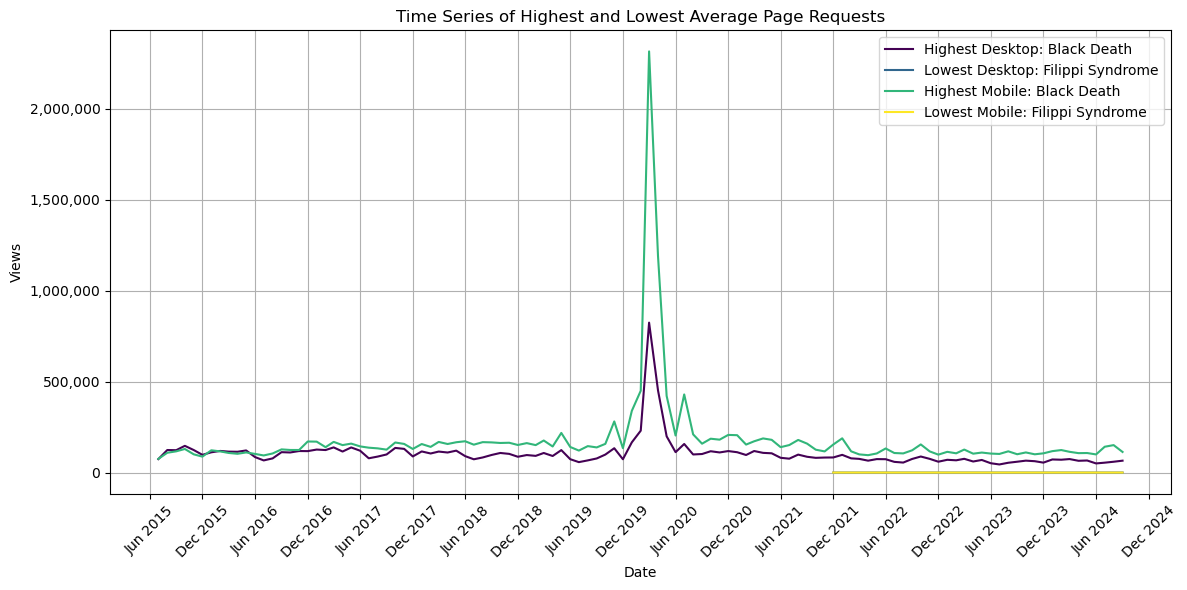

In [33]:
# VISUAL ANALYSIS

# Maximum Average and Minimum Average
# The first graph should contain time series for the articles that have the highest average page requests (views)
# and the lowest average page requests (views) for desktop access and mobile access over the entire time series. 
# Your graph should have four lines (max desktop, min desktop, max mobile, min mobile).


def calculate_average_views(file_path, excluded_titles):
    with open(file_path) as f:
        data = json.load(f)

    averages = {}
    monthly_views = {}

    for title, months in data.items():
        if title in excluded_titles:
            continue
        
        total_views = sum(month['views'] for month in months)
        averages[title] = total_views / len(months) if months else 0
        
        # Adjust timestamp format to match 'YYYYMMDDHH'
        monthly_views[title] = [(datetime.strptime(month['timestamp'], '%Y%m%d%H'), month['views']) for month in months]

    return averages, monthly_views

def find_high_low(averages):
    high = max(averages, key=averages.get)
    low = min(averages, key=averages.get)
    return high, low

# File paths
desktop_file = 'rare-disease_monthly_desktop_start201507-end202409.json'
mobile_file = 'rare-disease_monthly_mobile_start201507-end202409.json'

# Excluded titles
excluded_titles = [
    "Sulfadoxine/pyrimethamine",
    "Cystine/glutamate transporter",
    "Trimethoprim/sulfamethoxazole"
]

# Calculate averages and monthly views
desktop_averages, desktop_monthly_views = calculate_average_views(desktop_file, excluded_titles)
mobile_averages, mobile_monthly_views = calculate_average_views(mobile_file, excluded_titles)

# Find highest and lowest views
desktop_highest, desktop_lowest = find_high_low(desktop_averages)
mobile_highest, mobile_lowest = find_high_low(mobile_averages)

# Print the highest and lowest average views for desktop and mobile
print(f"Desktop Highest Average Views: {desktop_highest} with {desktop_averages[desktop_highest]:.2f} views")
print(f"Desktop Lowest Average Views: {desktop_lowest} with {desktop_averages[desktop_lowest]:.2f} views")
print(f"Mobile Highest Average Views: {mobile_highest} with {mobile_averages[mobile_highest]:.2f} views")
print(f"Mobile Lowest Average Views: {mobile_lowest} with {mobile_averages[mobile_lowest]:.2f} views")

# Prepare data for plotting
desktop_high_views = desktop_monthly_views[desktop_highest]
desktop_low_views = desktop_monthly_views[desktop_lowest]
mobile_high_views = mobile_monthly_views[mobile_highest]
mobile_low_views = mobile_monthly_views[mobile_lowest]

# Extract times and views for plotting
def extract_times_views(views_data):
    times = [item[0] for item in views_data]
    views = [item[1] for item in views_data]
    return times, views

desktop_high_times, desktop_high_values = extract_times_views(desktop_high_views)
desktop_low_times, desktop_low_values = extract_times_views(desktop_low_views)
mobile_high_times, mobile_high_values = extract_times_views(mobile_high_views)
mobile_low_times, mobile_low_values = extract_times_views(mobile_low_views)

# Create time series plot with Viridis color palette
plt.figure(figsize=(12, 6))

# Get viridis color palette
cmap = plt.get_cmap('viridis')
colors = cmap([0.0, 0.33, 0.66, 1.0])  # Get four evenly spaced colors from viridis

# Plot each line with viridis colors
plt.plot(desktop_high_times, desktop_high_values, label=f'Highest Desktop: {desktop_highest}', color=colors[0])
plt.plot(desktop_low_times, desktop_low_values, label=f'Lowest Desktop: {desktop_lowest}', color=colors[1])
plt.plot(mobile_high_times, mobile_high_values, label=f'Highest Mobile: {mobile_highest}', color=colors[2])
plt.plot(mobile_low_times, mobile_low_values, label=f'Lowest Mobile: {mobile_lowest}', color=colors[3])

# Graph settings
plt.title('Time Series of Highest and Lowest Average Page Requests')
plt.xlabel('Date')
plt.ylabel('Views')
plt.ticklabel_format(style='plain', axis='y')

# puts commas for better legibility
plt.gca().set_yticklabels([f'{int(y):,}' for y in plt.gca().get_yticks()])

# puts x ticks at every 6 months
locator = mdates.MonthLocator(interval=6)
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

# Show legend and grid
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/tr/2r9b6ycs2vg9ppvg336jkgw80000gn/T/ipykernel_741/3252703866.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(y):,}' for y in plt.gca().get_yticks()])


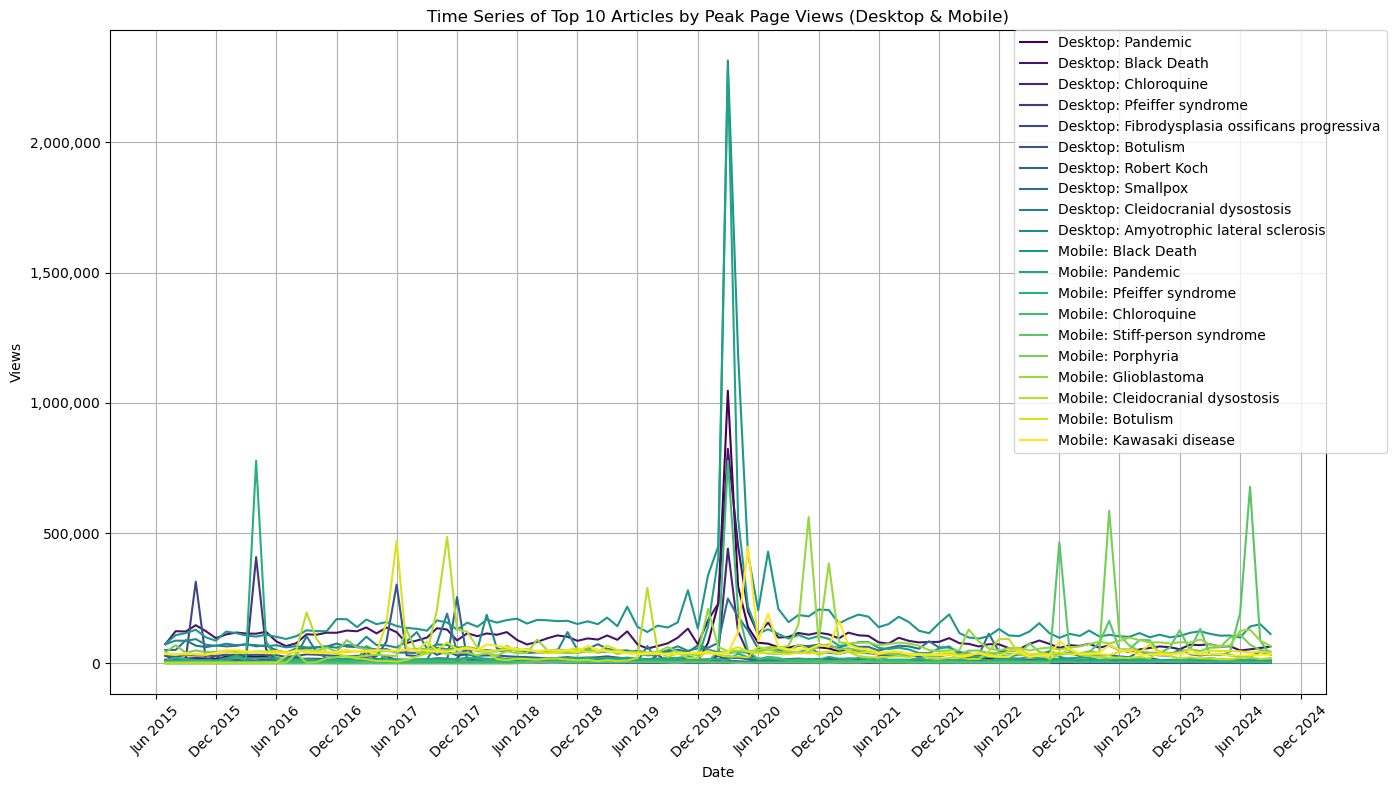

In [36]:
def find_peak_views(file_path, excluded_titles):
    with open(file_path) as f:
        data = json.load(f)

    peaks = {}
    monthly_views = {}

    for title, months in data.items():
        if title in excluded_titles:
            continue
        
        # Extract monthly views and find the peak
        views = [(datetime.strptime(month['timestamp'], '%Y%m%d%H'), month['views']) for month in months]
        peak_value = max(views, key=lambda x: x[1])[1]
        peaks[title] = peak_value
        
        # Store time series data for the article
        monthly_views[title] = views

    return peaks, monthly_views

def get_top_n_articles(peaks, n=10):
    # Sort articles by peak values and get the top N articles
    return sorted(peaks.keys(), key=lambda x: peaks[x], reverse=True)[:n]

# File paths
desktop_file = 'rare-disease_monthly_desktop_start201507-end202409.json'
mobile_file = 'rare-disease_monthly_mobile_start201507-end202409.json'

# Excluded titles
excluded_titles = [
    "Sulfadoxine/pyrimethamine",
    "Cystine/glutamate transporter",
    "Trimethoprim/sulfamethoxazole"
]

# Find peaks and monthly views
desktop_peaks, desktop_monthly_views = find_peak_views(desktop_file, excluded_titles)
mobile_peaks, mobile_monthly_views = find_peak_views(mobile_file, excluded_titles)

# Get top 10 articles by peak views
top_desktop_articles = get_top_n_articles(desktop_peaks, 10)
top_mobile_articles = get_top_n_articles(mobile_peaks, 10)

# Function to extract times and views for plotting
def extract_times_views(views_data):
    times = [item[0] for item in views_data]
    views = [item[1] for item in views_data]
    return times, views

# Create time series plot with Viridis color palette
plt.figure(figsize=(14, 8))
cmap = plt.get_cmap('viridis')
colors = cmap([i / 19 for i in range(20)])  # 20 evenly spaced colors (10 desktop + 10 mobile)

# Plot top 10 desktop articles
for i, title in enumerate(top_desktop_articles):
    times, values = extract_times_views(desktop_monthly_views[title])
    plt.plot(times, values, label=f'Desktop: {title}', color=colors[i])

# Plot top 10 mobile articles
for i, title in enumerate(top_mobile_articles):
    times, values = extract_times_views(mobile_monthly_views[title])
    plt.plot(times, values, label=f'Mobile: {title}', color=colors[10 + i])

# Graph settings
plt.title('Time Series of Top 10 Articles by Peak Page Views (Desktop & Mobile)')
plt.xlabel('Date')
plt.ylabel('Views')

# Disable scientific notation on y-axis
plt.ticklabel_format(style='plain', axis='y')

# Format y-ticks with commas
plt.gca().set_yticklabels([f'{int(y):,}' for y in plt.gca().get_yticks()])

# Set x-ticks to show every 6 months
locator = mdates.MonthLocator(interval=6)
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Rotate x-tick labels
plt.xticks(rotation=45)

# Show legend and grid
plt.legend(ncol=2)  # Display the legend in two columns
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0.)

# Adjust layout
plt.tight_layout()
plt.show()


/var/folders/tr/2r9b6ycs2vg9ppvg336jkgw80000gn/T/ipykernel_741/397160216.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(y):,}' for y in plt.gca().get_yticks()])


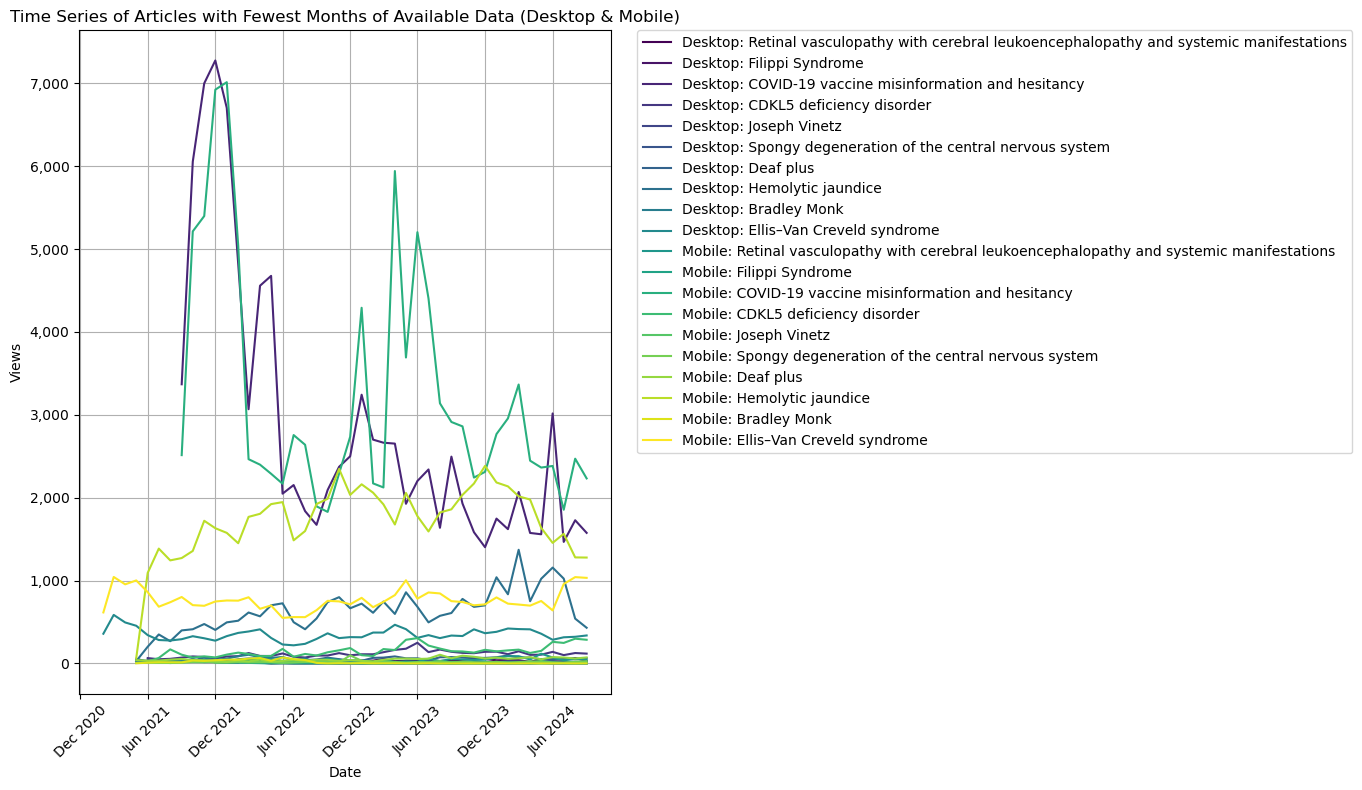

In [41]:
def count_available_months(file_path, excluded_titles):
    with open(file_path) as f:
        data = json.load(f)

    available_months = {}
    monthly_views = {}

    for title, months in data.items():
        if title in excluded_titles:
            continue
        
        # Count available months and store monthly views
        available_month_count = len(months)
        available_months[title] = available_month_count
        
        # Store time series data for the article
        views = [(datetime.strptime(month['timestamp'], '%Y%m%d%H'), month['views']) for month in months]
        monthly_views[title] = views

    return available_months, monthly_views

def get_least_n_articles(available_months, n=10):
    # Sort articles by available months and get the least N articles
    return sorted(available_months.keys(), key=lambda x: available_months[x])[:n]

# File paths
desktop_file = 'rare-disease_monthly_desktop_start201507-end202409.json'
mobile_file = 'rare-disease_monthly_mobile_start201507-end202409.json'

# Excluded titles
excluded_titles = [
    "Sulfadoxine/pyrimethamine",
    "Cystine/glutamate transporter",
    "Trimethoprim/sulfamethoxazole"
]

# Count available months and get monthly views
desktop_available_months, desktop_monthly_views = count_available_months(desktop_file, excluded_titles)
mobile_available_months, mobile_monthly_views = count_available_months(mobile_file, excluded_titles)

# Get least 10 articles by available months
least_desktop_articles = get_least_n_articles(desktop_available_months, 10)
least_mobile_articles = get_least_n_articles(mobile_available_months, 10)

# Function to extract times and views for plotting
def extract_times_views(views_data):
    times = [item[0] for item in views_data]
    views = [item[1] for item in views_data]
    return times, views

# Create time series plot with Viridis color palette
plt.figure(figsize=(14, 8))

# Get viridis color palette
cmap = plt.get_cmap('viridis')
colors = cmap([i / 19 for i in range(20)])  # 20 evenly spaced colors (10 desktop + 10 mobile)

# Plot least 10 desktop articles
for i, title in enumerate(least_desktop_articles):
    times, values = extract_times_views(desktop_monthly_views[title])
    plt.plot(times, values, label=f'Desktop: {title}', color=colors[i])

# Plot least 10 mobile articles
for i, title in enumerate(least_mobile_articles):
    times, values = extract_times_views(mobile_monthly_views[title])
    plt.plot(times, values, label=f'Mobile: {title}', color=colors[10 + i])

# Graph settings
plt.title('Time Series of Articles with Fewest Months of Available Data (Desktop & Mobile)')
plt.xlabel('Date')
plt.ylabel('Views')

# Disable scientific notation on y-axis
plt.ticklabel_format(style='plain', axis='y')

# Format y-ticks with commas
plt.gca().set_yticklabels([f'{int(y):,}' for y in plt.gca().get_yticks()])

# Set x-ticks to show every 6 months
locator = mdates.MonthLocator(interval=6)
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Rotate x-tick labels
plt.xticks(rotation=45)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#plt.legend(ncol=2)  # Display the legend in two columns
plt.grid(True)


# Adjust layout
plt.tight_layout()
plt.show()
